## Setting up environment

In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotel-booking-demand/hotel_bookings.csv


In [67]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Load data

In [68]:
import pandas as pd

# Load dataset
orig_dataset = pd.read_csv("../input/hotel-booking-demand/hotel_bookings.csv");
orig_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Split data
Split data into train and test dataset. <br> 
Select and explore only train dataset to avoid training bias from test set.

In [69]:
import numpy as np
import matplotlib.pyplot as plt 
    
# Explore missing data in dataset
print(orig_dataset.isnull().sum())

# Drop duplicate rows
orig_dataset.drop_duplicates(inplace= True)

# Convert data type
orig_dataset['children'] = orig_dataset['children'].astype('Int64')

# Handling null value
orig_dataset.drop(['company', 'agent'], axis=1, inplace= True)   # Drop features with lots of missing value out
orig_dataset['country'].fillna(method='ffill', inplace=True)  # Impute missing data with LOCF method
orig_dataset = orig_dataset[orig_dataset['children'].notna()]   # Drop missing data rows

print(orig_dataset.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [70]:
from sklearn.model_selection import train_test_split

# Select features and label
features = orig_dataset.drop(['is_canceled'], axis=1)
label = orig_dataset['is_canceled']

# Split train test data
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state= 3)

In [71]:
explore_data = pd.concat([X_train, y_train], axis=1).copy()

explore_data.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'is_canceled'],
      dtype='object')

## EDA - Exploratory Data Analysis
Investigate the hidden pattern, information in data

### 1. Time series analysis
The below graphs show the amount of lodging detail in each time of year.

<AxesSubplot:xlabel='arrival_date_month'>

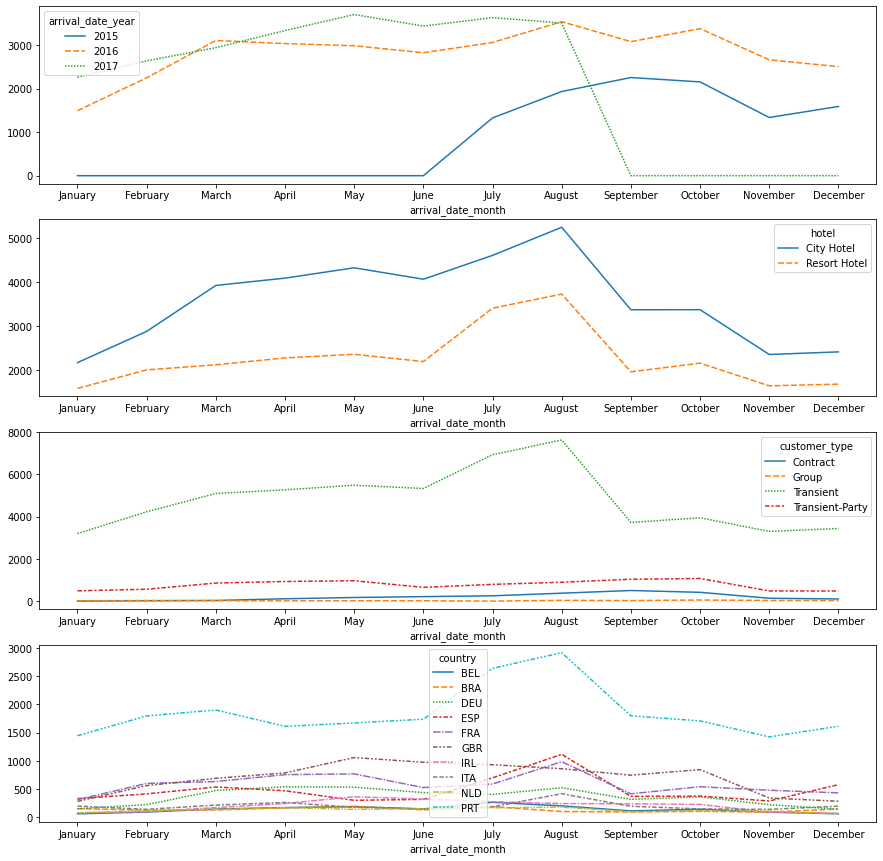

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create dict for sorting purpose
month_dict = {'January': 0, 'February': 1, 'March': 2, 'April': 3, 'May': 4, 'June': 5, 'July': 6, 'August': 7, 'September': 8, 'October': 9, 'November': 10, 'December': 11} 

_, axs = plt.subplots(4, 1, figsize = (15,15))

# Amount of lodging in each month separated by years
loding_trend = pd.crosstab(explore_data['arrival_date_month'], explore_data['arrival_date_year'])
loding_trend = loding_trend.sort_values(by=['arrival_date_month'], key=lambda x: x.map(month_dict))
sns.lineplot(data=loding_trend, ax=axs[0])

# Amount of hotel reserved in each month
hotel_type = pd.crosstab(explore_data['arrival_date_month'], explore_data['hotel'])
hotel_type = hotel_type.sort_values(by=['arrival_date_month'], key=lambda x: x.map(month_dict))
sns.lineplot(data= hotel_type, ax=axs[1])

# Amount of customer type lodge the hotel in each month
customer_type_month = pd.crosstab(explore_data['arrival_date_month'], explore_data['customer_type'])
customer_type_month = customer_type_month.sort_values(by=['arrival_date_month'], key=lambda x: x.map(month_dict))
sns.lineplot(data= customer_type_month, ax=axs[2])

# Amount of customer country lodge the hotel in each month
top10_country = explore_data['country'].value_counts().head(10).index
country_month = explore_data.loc[explore_data['country'].isin(top10_country), ['arrival_date_month', 'country']]
country_month = pd.crosstab(country_month['arrival_date_month'], country_month['country'])
country_month = country_month.sort_values(by=['arrival_date_month'], key=lambda x: x.map(month_dict))
sns.lineplot(data= country_month, ax=axs[3])

### Observations
Exploring time series is exposed the useful information as listed below
* Around third quarter of each year will have the most of lodging transactions and will start decrease in the fourth quarter. <br>
* City and resort hotel have similar demand growth along the year. <br>
* Transient type has significantly larger demand than the others along the year <br>
* BEL is the country that most lodging the hotel.

### 2. Bivariate analysis
This section is trying to find the hidden pattern or relation between interested features and a target feature. <br>
Moreover, trying to prove the assumptions that came in to my mind.

**2.1 Cancellation due to days in waiting list**

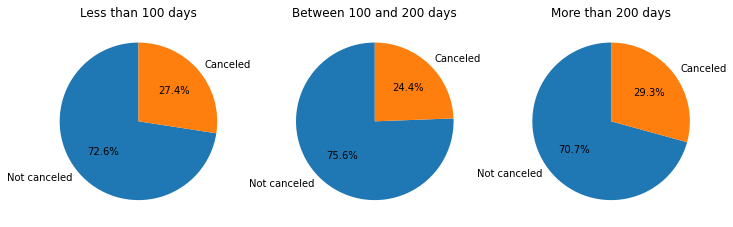

In [73]:
# Find ratio of cancellation due to days in waiting list

# Separate into three groups
cancel_because_waiting1  = explore_data.loc[(explore_data['days_in_waiting_list'] >= 0) & (explore_data['days_in_waiting_list'] < 100), ['days_in_waiting_list', 'is_canceled'] ]
cancel_because_waiting2  = explore_data.loc[(explore_data['days_in_waiting_list'] >= 100) & (explore_data['days_in_waiting_list'] < 200), ['days_in_waiting_list', 'is_canceled'] ]
cancel_because_waiting3  = explore_data.loc[(explore_data['days_in_waiting_list'] >= 200) , ['days_in_waiting_list', 'is_canceled'] ]

# Calculate in percentage
cancel_because_waiting1 = cancel_because_waiting1['is_canceled'].value_counts(normalize=True) * 100
cancel_because_waiting2 = cancel_because_waiting2['is_canceled'].value_counts(normalize=True) * 100
cancel_because_waiting3 = cancel_because_waiting3['is_canceled'].value_counts(normalize=True) * 100

# Plot
_, axs = plt.subplots(1, 3, figsize=(12, 18))
axs[0].pie(cancel_because_waiting1, labels = ['Not canceled', 'Canceled'], autopct='%1.1f%%', startangle=90)
axs[1].pie(cancel_because_waiting2, labels = ['Not canceled', 'Canceled'], autopct='%1.1f%%', startangle=90)
axs[2].pie(cancel_because_waiting3, labels = ['Not canceled', 'Canceled'], autopct='%1.1f%%', startangle=90)

axs[0].title.set_text('Less than 100 days')
axs[1].title.set_text('Between 100 and 200 days')
axs[2].title.set_text('More than 200 days')

plt.show()

### Observations
Investigating the cancellation due to days in waiting list. <br>
I assumed that longer time the customers waiting in the list will make them likely decide to cancel the lodging because of dissatifaction of service. <br>
I have try below steps to visualize data:
1. Split the time which customers use to wait in the list into three groups. Less than 100 days, more than 100 days but less than 200 days and more than 200 days.
2. Calculate the percentage amount of cancel or not cancel for each group.
3. Visualize each group in pie charts. <br>

The apparent result shows that the longer time used is not significantly affect the cancellation decision.


**2.2 Cancellation due to prvious cancellation**

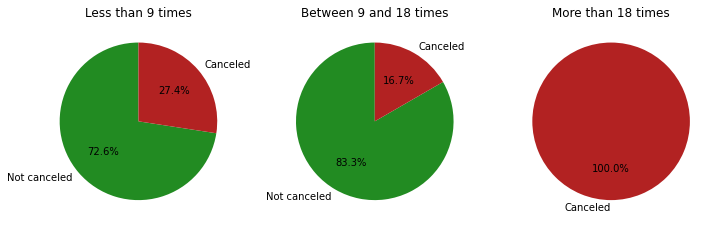

In [74]:
# Find ratio of cancellation due to previous cancellation

# Separate into three segments
previous_cancel1 = explore_data.loc[ explore_data['previous_cancellations'] < 9, ['previous_cancellations', 'is_canceled']]
previous_cancel2 = explore_data.loc[ (explore_data['previous_cancellations'] >= 9) & (explore_data['previous_cancellations'] < 18), ['previous_cancellations', 'is_canceled']]
previous_cancel3 = explore_data.loc[ explore_data['previous_cancellations'] >= 18, ['previous_cancellations', 'is_canceled']]

# Calculate in percentage 
previous_cancel1 = previous_cancel1['is_canceled'].value_counts(normalize=True) * 100
previous_cancel2 = previous_cancel2['is_canceled'].value_counts(normalize=True) * 100
previous_cancel3 = previous_cancel3['is_canceled'].value_counts(normalize=True) * 100

# Simulate
_, axs = plt.subplots(1, 3, figsize=(12, 18))
axs[0].pie(previous_cancel1, labels = ['Not canceled', 'Canceled'], autopct='%1.1f%%', startangle=90, colors=['forestgreen', 'firebrick'])
axs[1].pie(previous_cancel2, labels = ['Not canceled', 'Canceled'], autopct='%1.1f%%', startangle=90, colors=['forestgreen', 'firebrick'])
axs[2].pie(previous_cancel3, labels = ['Canceled'], autopct='%1.1f%%', startangle=90, colors=['firebrick'])

axs[0].title.set_text('Less than 9 times')
axs[1].title.set_text('Between 9 and 18 times')
axs[2].title.set_text('More than 18 times')

plt.show()

**2.3 Cancellation due to distribution channel**

Text(0.5, 1.0, 'Portion of cancellation for each channel')

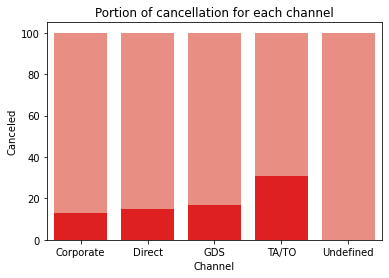

In [75]:
# Compare percentage of cancellation for each distribution channel

# Create cross tab
channels = pd.crosstab(explore_data['is_canceled'], explore_data['distribution_channel']) 

# Calculate percentage separated by channel
channels = pd.DataFrame([ channels[channel] / channels[channel].sum() * 100 for channel in channels ])

x = channels.reset_index().rename(columns={'index': 'Channel', 0:'Not canceled', 1: 'Canceled'})
x = pd.concat( [x, pd.DataFrame([100] * 5)], axis=1)
sns.barplot(x='Channel', y=0, data=x, color='salmon')
sns.barplot(x='Channel', y='Canceled', data=x, color='red')
plt.title('Portion of cancellation for each channel')

**2.4 Cancellation due to customer segment**

Text(0.5, 1.0, 'Portion of cancellation for each customer type')

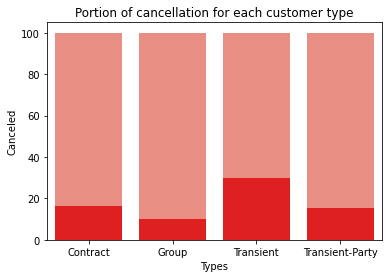

In [76]:
# Compare percentage of cancellation for each distribution channel

# Create cross tab
cus_types = pd.crosstab(explore_data['is_canceled'], explore_data['customer_type']) 

# Calculate percentage separated by channel
cus_types = pd.DataFrame([ cus_types[cus_type] / cus_types[cus_type].sum() * 100 for cus_type in cus_types ])

x = cus_types.reset_index().rename(columns={'index': 'Types', 0:'Not canceled', 1: 'Canceled'})
x = pd.concat( [x, pd.DataFrame([100] * 5)], axis=1)
sns.barplot(x='Types', y=0, data=x, color='salmon')
sns.barplot(x='Types', y='Canceled', data=x, color='red')
plt.title('Portion of cancellation for each customer type')

**2.5 Cancellation due to repeated guest**

Text(0.5, 1.0, 'Portion of cancellation for each repeated and not repeated guest')

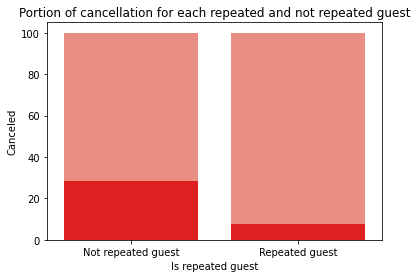

In [77]:
# Explore relation between customer used to be guest before and cancellation
cross_cancel = pd.crosstab(explore_data['is_canceled'], explore_data['is_repeated_guest'])
cross_cancel = cross_cancel.rename({0: 'Not repeated guest', 1: 'Repeated guest'}, axis=1)
cross_cancel = pd.DataFrame([cross_cancel[guest] / cross_cancel[guest].sum() * 100 for guest in cross_cancel ]).reset_index()
cross_cancel = cross_cancel.rename({'index': 'Is repeated guest', 0: 'Not canceled', 1: 'Canceled'}, axis=1)
cross_cancel = pd.concat([cross_cancel, pd.DataFrame([100] * 2)], axis=1)

# Visualize
sns.barplot(x= 'Is repeated guest', y= 0, data= cross_cancel, color='salmon')
sns.barplot(x= 'Is repeated guest', y= 'Canceled', data= cross_cancel, color='red')
plt.title('Portion of cancellation for each repeated and not repeated guest')

## Feature engineering
Investigate features to find the appropriate features for prediction

In [78]:
explore_data.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'is_canceled'],
      dtype='object')

Text(0.5, 1.0, 'Portion of cancellation in dataset')

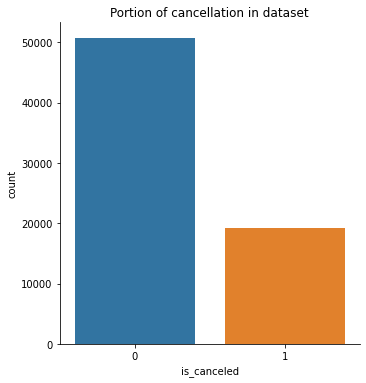

In [79]:
# Investigate imbalanced data
sns.catplot(x= 'is_canceled', kind= 'count', data=explore_data)
plt.title('Portion of cancellation in dataset')

### Construct new features from features

In [80]:
# Find the total amount of guest
explore_data.loc[:, 'total_guest'] = explore_data['adults'] + explore_data['children'] + explore_data['babies']
X_train.loc[:, 'total_guest'] = (X_train['adults'] + X_train['children'] + X_train['babies']).copy()
X_test.loc[:, 'total_guest'] = (X_test['adults'] + X_test['children'] + X_test['babies']).copy()

# Find the problability of customers who likely to cancel the lodging by determining from previous cancellations
explore_data.loc[:, 'cancellation_rate'] = explore_data['previous_cancellations'] / (explore_data['previous_cancellations'] + explore_data['previous_bookings_not_canceled'])
# In case customers have never lodge, the rate will be -1
explore_data.loc[:, 'cancellation_rate'] = explore_data['cancellation_rate'].fillna(-1)

X_train.loc[:, 'cancellation_rate'] = (X_train['previous_cancellations'] / (X_train['previous_cancellations'] + X_train['previous_bookings_not_canceled'])).copy()
X_train.loc[:, 'cancellation_rate'].fillna(-1, inplace=True)

X_test.loc[:, 'cancellation_rate'] = (X_test['previous_cancellations'] / (X_test['previous_cancellations'] + X_test['previous_bookings_not_canceled'])).copy()
X_test.loc[:, 'cancellation_rate'].fillna(-1, inplace= True)

# Find the total nights customers stay
explore_data.loc[:, 'total_nights_stay'] = explore_data['stays_in_week_nights'] + explore_data['stays_in_weekend_nights']
X_train.loc[:, 'total_nights_stay'] = (X_train['stays_in_week_nights'] + X_train['stays_in_weekend_nights']).copy()
X_test.loc[:, 'total_nights_stay'] = (X_test['stays_in_week_nights'] + X_test['stays_in_weekend_nights']).copy()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [81]:
# Categorize data into two types
numerical_data = explore_data.select_dtypes(include=['int64', 'float64']).columns
categorical_data = explore_data.select_dtypes(include=['object']).columns

Text(0.5, 1.0, 'Heat map of numerical correlation')

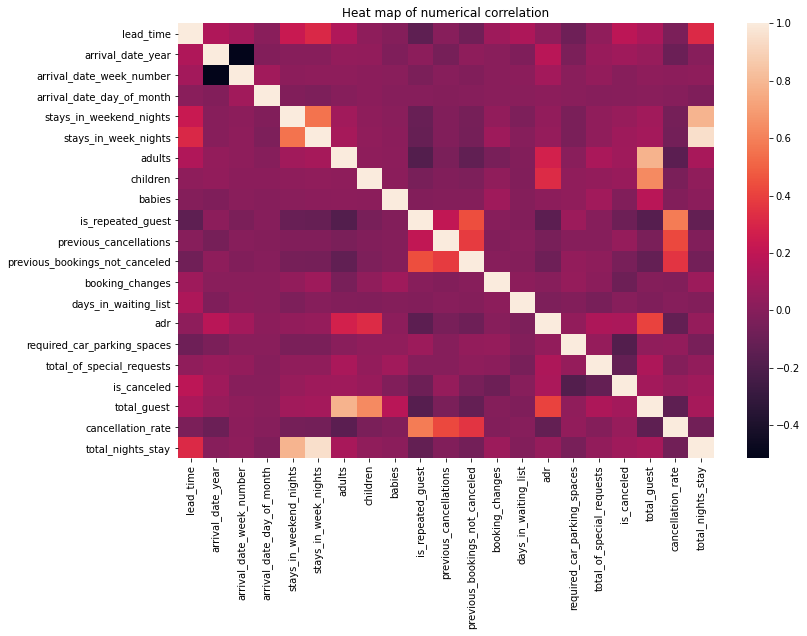

In [82]:
# Declare variable for keeping selected categorical features
selected_num = []

# Explore corrlation of numerical variables
plt.figure(figsize= (12,8))
features_corr = explore_data[numerical_data].corr()
sns.heatmap(features_corr)

# Select features from numerical features
sig_features = features_corr['is_canceled'].sort_values().drop('is_canceled', axis=0)
selected_num.extend(sig_features.head(3).index.tolist())
selected_num.extend(sig_features.tail(3).index.tolist())
plt.title('Heat map of numerical correlation')

In [85]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Declare variable for keeping selected numerical features
selected_cate = []

# Explore chi-square of categorical variables
for cat in categorical_data:
    contingency_tab = pd.crosstab(explore_data[cat], explore_data['is_canceled'])
    stat, p, dof, expected = chi2_contingency(contingency_tab)
    # Select features with p-value less than 0.05     
    if p < 0.05 and cat != 'reservation_status':
        selected_cate.append(cat)
    print('p-value of {} is {}'.format(cat, p))

p-value of hotel is 5.720521108140805e-83
p-value of arrival_date_month is 1.9118759472625792e-100
p-value of meal is 3.5287975975188065e-61
p-value of country is 0.0
p-value of market_segment is 0.0
p-value of distribution_channel is 0.0
p-value of reserved_room_type is 2.276219836179873e-45
p-value of assigned_room_type is 6.024707084280727e-126
p-value of deposit_type is 0.0
p-value of customer_type is 6.756404091331245e-243
p-value of reservation_status is 0.0
p-value of reservation_status_date is 0.0


In [86]:
print('Selected categorical features: {}'.format(selected_cate))
print('Selected numerical features: {}'.format(selected_num))

Selected categorical features: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status_date']
Selected numerical features: ['required_car_parking_spaces', 'total_of_special_requests', 'booking_changes', 'total_guest', 'adr', 'lead_time']


# Preprocessing

In [87]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

selected_features = selected_cate.copy()
selected_cate.remove('arrival_date_month')

# Deine pipeline for transforming each feaure type separately
preprocessor = ColumnTransformer([
        ('scaler', StandardScaler(), pd.Index(selected_num)),
        ('one_hot', OneHotEncoder(), pd.Index(selected_cate)),
        ('ordinal_enc', OrdinalEncoder(categories= [months]), pd.Index(['arrival_date_month']))
])

# Modeling
Try multiple algorithms to fit the data

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

# Define model training pipelines
lgs = Pipeline([('preprocess', preprocessor),
                ('logistic', LogisticRegression(max_iter=300))])

svm = Pipeline([('preprocess', preprocessor),
                ('svm', svm.SVC(max_iter=300))])

tree = Pipeline([('preprocess', preprocessor),
                ('decisionTree', DecisionTreeClassifier())])

In [89]:
from sklearn.model_selection import cross_val_score

selected_features =  selected_num + selected_cate + ['arrival_date_month']
X_train = X_train[selected_features].copy()
X_test = X_test[selected_features].copy()

lgs_cv = cross_val_score(lgs, X_train, y_train, cv=5)
svm_cv = cross_val_score(svm, X_train, y_train, cv=5)
tree_cv = cross_val_score(tree, X_train, y_train, cv=5)

In [90]:
print('Logistic Regression mean: {}'.format(lgs_cv.mean()))
print('SVM mean: {}'.format(svm_cv.mean()))
print('Decision Tree mean: {}'.format(tree_cv.mean()))

Logistic Regression mean: 0.8220073708032558
SVM mean: 0.5318897981776981
Decision Tree mean: 0.8089053975497332


In [91]:
# Fit the model
lgs_model = lgs.fit(X_train, y_train)
svm_model = svm.fit(X_train, y_train)
tree_model = tree.fit(X_train, y_train)

# Predict the result
lgs_pred = lgs_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
tree_pred = tree_model.predict(X_test)

# Show classification report
print(classification_report(y_test, lgs_pred), end='\n\n')
print(classification_report(y_test, svm_pred), end='\n\n')
print(classification_report(y_test, tree_pred), end='\n\n')

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     12629
           1       0.75      0.55      0.64      4850

    accuracy                           0.82     17479
   macro avg       0.80      0.74      0.76     17479
weighted avg       0.82      0.82      0.81     17479


              precision    recall  f1-score   support

           0       0.75      0.65      0.69     12629
           1       0.32      0.43      0.37      4850

    accuracy                           0.59     17479
   macro avg       0.53      0.54      0.53     17479
weighted avg       0.63      0.59      0.60     17479


              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12629
           1       0.68      0.65      0.66      4850

    accuracy                           0.82     17479
   macro avg       0.77      0.77      0.77     17479
weighted avg       0.82      0.82      0.82     17479




# Parameter Tuning
Select best type of model which can be fitted to data from past section and tune the parameters with GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define options
tree_params = {
  'decisionTree__criterion': ['gini', 'entropy'],
  'decisionTree__splitter': ['best', 'random'],
  'decisionTree__max_depth': [3,4,5,6,7,8,9,10],
  'decisionTree__min_samples_leaf': [1,2,3,4,5],
  'decisionTree__min_samples_split': [2,3,4,5]
} 

# Define GridSearchCV
model = GridSearchCV(estimator=tree,
            param_grid=tree_params,
            scoring='accuracy',
            cv=10)

# Train, predict and evaluate
model.fit(X_train, y_train)
print('Best params are: {}'.format(model.best_params_))
print('Best training accuracy: {}'.format(model.best_score_))
y_pred = model.predict(X_test)
print('Test set accuracy: {}'.format(accuracy_score(y_test, y_pred)))